### Image data
The goal of this notebook is to train and evaluated HT risk classification using statistics from the images and the faces detect in the images associated to the set of ads provided for the CP1 during the MEMEX Winter QPR 2017.
[Most of the code from Mayank repo]

### Input files
1. clusters images based features for training and testing

### Outputs
1. eval file

In [92]:
import os
import json
import codecs
import re
import numpy as np
from random import shuffle

In [93]:
def convert_string_to_float_list(string):
    return [float(i) for i in re.split(', ', string[1:-1])]

In [94]:
def l2_norm_on_matrix(matrix):
    """
    Takes a np.matrix style object and l2-normalizes it.
    :param matrix:
    :return matrix:
    """
    from sklearn.preprocessing import normalize
    warnings.filterwarnings("ignore")
    return normalize(matrix)

In [95]:
def sample_and_extend(list_of_vectors, total_samples):
    """
    Oversampling code for balanced training. We will do deep re-sampling, assuming that the vectors contain
    atoms.
    :param list_of_vectors: the list of vectors that are going to be re-sampled (randomly)
    :param total_samples: The total number of vectors that we want in the list. Make sure that this number
    is higher than the length of list_of_vectors
    :return: the over-sampled list
    """
    if len(list_of_vectors) >= total_samples:
        raise Exception('Check your lengths!')

    indices = range(0, len(list_of_vectors))
    shuffle(indices)
    desired_samples = total_samples-len(list_of_vectors)
    # print desired_samples>len(list_of_vectors)
    while desired_samples > len(indices):
        new_indices = list(indices)
        shuffle(new_indices)
        indices += new_indices
    new_data = [list(list_of_vectors[i]) for i in indices[0:desired_samples]]
    # print new_data
    return np.append(list_of_vectors, new_data, axis=0)

In [96]:
def prepare_for_ML_classification(pos_neg_file, normalize=False):
    """
    We need to read in embeddings
    :param pos_neg_file: The file generated in one of the preprocess_filtered_* files
    :return: A dictionary where a 0,1 label references a numpy matrix.
    """
    result = dict()
    pos_features = list()
    neg_features = list()
    with codecs.open(pos_neg_file, 'r', 'utf-8') as f:
        for line in f:
            line = line[0:-1]
            cols = re.split('\t',line)
            # print list(cols[1])
            # break
            if int(cols[2]) == 1:
                pos_features.append(convert_string_to_float_list(cols[1]))
            elif int(cols[2]) == 0:
                neg_features.append(convert_string_to_float_list(cols[1]))
            else:
                print 'error; label not recognized'
    # print np.matrix(pos_features)
    if normalize == True:
        result[0] = l2_norm_on_matrix(np.matrix(neg_features))
        result[1] = l2_norm_on_matrix(np.matrix(pos_features))
    else:
        if len(pos_features) != 0:
            result[1] = pos_features
        if len(neg_features) != 0:
            result[0] = neg_features
    return result

In [97]:
def prepare_train_test_data(pos_neg_file, train_percent = 0.3, randomize=True, balanced_training=True, data_vectors=None):
    """
    :param pos_neg_file:
    :param train_percent:
    :param randomize: If true, we'll randomize the data we're reading in from pos_neg_file. Otherwise, the initial
    train_percent fraction goes into the training data and the rest of it in the test data
    :param balanced_training: if True, we will equalize positive and negative training samples by oversampling
    the lesser class. For example, if we have 4 positive samples and 7 negative samples, we will randomly re-sample
    3 positive samples from the 4 positive samples, meaning there will be repetition. Use with caution.
    :param data_vectors: this should be set if pos_neg_file is None. It is mostly for internal uses, so
    that we can re-use this function by invoking it from some of the other _prepare_ files.
    :return: dictionary containing training/testing data/labels
    """
    import math
    if pos_neg_file:
        data = prepare_for_ML_classification(pos_neg_file)
    elif data_vectors:
        data = data_vectors
    else:
        raise Exception('Neither pos_neg_file nor data_vectors argument is specified. Exiting.')

    # print len(data[1])
    # print len(data[0])
    train_pos_num = int(math.ceil(len(data[1])*train_percent))
    train_neg_num = int(math.ceil(len(data[0])*train_percent))
    # print train_pos_num
    # print train_neg_num
    test_pos_num = len(data[1])-train_pos_num
    test_neg_num = len(data[0])-train_neg_num
    if test_pos_num == 0:
        test_pos_num = 1
    if test_neg_num == 0:
        test_neg_num = 1

    test_labels_pos = [[1] * test_pos_num]
    test_labels_neg = [[0] * test_neg_num]

    if not randomize:
        train_data_pos = data[1][0:train_pos_num]
        train_data_neg = data[0][0:train_neg_num]
        if train_pos_num < len(data[1]):
            test_data_pos = data[1][train_pos_num:]
        else:
            test_data_pos = [data[1][-1]]

        if train_neg_num < len(data[0]):
            test_data_neg = data[0][train_neg_num:]
        else:
            test_data_neg = [data[0][-1]]

    else:
        all_pos_indices = range(0, len(data[1]))
        all_neg_indices = range(0, len(data[0]))
        shuffle(all_pos_indices)
        shuffle(all_neg_indices)

        train_data_pos = [data[1][i] for i in all_pos_indices[0:train_pos_num]]
        train_data_neg = [data[0][i] for i in all_neg_indices[0:train_neg_num]]

        if train_pos_num < len(data[1]):
            test_data_pos = [data[1][i] for i in all_pos_indices[train_pos_num:]]
        else:
            test_data_pos = [data[1][-1]]

        if train_neg_num < len(data[0]):
            test_data_neg = [data[0][i] for i in all_neg_indices[train_neg_num:]]
        else:
            test_data_neg = [data[0][-1]]

    if balanced_training:
        if train_pos_num < train_neg_num:
            train_labels_pos = [[1] * train_neg_num]
            train_labels_neg = [[0] * train_neg_num]
            train_data_pos = sample_and_extend(train_data_pos, total_samples=train_neg_num)
        elif train_pos_num > train_neg_num:
            train_labels_pos = [[1] * train_pos_num]
            train_labels_neg = [[0] * train_pos_num]
            train_data_neg = sample_and_extend(train_data_neg, total_samples=train_pos_num)
        else:
            train_labels_pos = [[1] * train_pos_num]
            train_labels_neg = [[0] * train_neg_num]
    else:
        train_labels_pos = [[1] * train_pos_num]
        train_labels_neg = [[0] * train_neg_num]

    # print len(train_data_pos)
    # print len(train_data_neg)
    train_data = np.append(train_data_pos, train_data_neg, axis=0)
    test_data = np.append(test_data_pos, test_data_neg, axis=0)
    train_labels = np.append(train_labels_pos, train_labels_neg)
    test_labels = np.append(test_labels_pos, test_labels_neg)

    results = dict()
    results['train_data'] = train_data
    results['train_labels'] = train_labels
    results['test_data'] = test_data
    results['test_labels'] = test_labels

    return results

In [98]:
def get_pos_neg_ids(pos_neg_file):
    result = list()
    with codecs.open(pos_neg_file, 'r', 'utf-8') as f:
        for line in f:
            line = line[0:-1]
            result.append(re.split('\t',line)[0])
    return result

In [99]:
def prepare_train_test_data_separate_unseen(pos_neg_train_file, pos_neg_test_file, balanced_training=True):
    import numpy as np
    train = prepare_for_ML_classification(pos_neg_train_file)
    test = prepare_for_ML_classification(pos_neg_test_file)
    test_ids = get_pos_neg_ids(pos_neg_test_file)
    train_pos_num = len(train[1])
    train_neg_num = len(train[0])

    train_data_pos = train[1][0:train_pos_num]
    train_data_neg = train[0][0:train_neg_num]

    #test_pos_num = len(test[1])
    test_neg_num = len(test[0])
    #test_data_pos = test[1][0:test_pos_num]
    test_data_neg = test[0][0:test_neg_num]
    #test_labels_pos = [[1] * test_pos_num]
    test_labels_neg = [[0] * test_neg_num]

    if balanced_training:
        if train_pos_num < train_neg_num:
            train_labels_pos = [[1] * train_neg_num]
            train_labels_neg = [[0] * train_neg_num]
            train_data_pos = sample_and_extend(train_data_pos, total_samples=train_neg_num)
        elif train_pos_num > train_neg_num:
            train_labels_pos = [[1] * train_pos_num]
            train_labels_neg = [[0] * train_pos_num]
            train_data_neg = sample_and_extend(train_data_neg, total_samples=train_pos_num)
        else:
            train_labels_pos = [[1] * train_pos_num]
            train_labels_neg = [[0] * train_neg_num]
    else:
        train_labels_pos = [[1] * train_pos_num]
        train_labels_neg = [[0] * train_neg_num]

    # print len(train_data_pos)
    # print len(train_data_neg)
    train_data = np.append(train_data_pos, train_data_neg, axis=0)
    #test_data = np.append(test_data_neg, axis=0)
    train_labels = np.append(train_labels_pos, train_labels_neg)
    #test_labels = np.append(test_labels_neg)

    results = dict()
    results['train_data'] = train_data
    results['train_labels'] = train_labels
    results['test_data'] = test_data_neg
    results['test_labels'] = test_labels_neg
    results['test_ids'] = test_ids

    return results

In [118]:
def train_and_test_classifier(train_data, train_labels, test_data, test_labels, classifier_model, test_ids=None):
        """
        Take three numpy matrices and compute a bunch of metrics. Hyperparameters must be changed manually,
        we do not take them in as input.
        This method is for BINARY CLASSIFICATION only, although there is some support for regression.
        :param train_data:
        :param train_labels:
        :param test_data:
        :param test_labels:
        :param classifier_model:
        :return:
        """
        from sklearn.linear_model import LogisticRegression, LinearRegression
        from sklearn.ensemble import RandomForestClassifier
        from sklearn import neighbors
        from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, precision_recall_fscore_support
        if classifier_model == 'random_forest':
            model = RandomForestClassifier()
        elif classifier_model == 'knn':
            k = 9
            model = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
        elif classifier_model == 'logistic_regression':
            model = LogisticRegression()
        elif classifier_model == 'linear_regression': # this is a regressor; be careful.
            model = LinearRegression()
        
        model.fit(train_data, train_labels)
        predicted_labels = model.predict(test_data)
        print predicted_labels
        print test_labels
        predicted_probabilities = model.predict_proba(test_data)
        #print predicted_probabilities

        final_results = list()
        if test_ids is not None:
            final_results.append(test_ids)
            final_results.append(predicted_probabilities)
            return final_results, model
        else:
            print 'AUC (Area Under Curve): ',
            print roc_auc_score(test_labels, predicted_labels)

        # precision, recall, thresholds = precision_recall_curve(test_labels, predicted_labels)
        # plt.clf()
        # plt.plot(recall, precision, label='precision-recall-curve')
        # plt.xlabel('Recall')
        # plt.ylabel('Precision')
        # plt.ylim([0.0, 1.05])
        # plt.xlim([0.0, 1.0])
        # plt.title('Precision-Recall curve')
        # plt.savefig('/home/mayankkejriwal/Downloads/memex-cp4-october/tmp/fig.png')
        if classifier_model not in ['linear_regression']:
            print 'Accuracy: ',
            print accuracy_score(test_labels, predicted_labels)
            # print precision_score(test_labels, predicted_labels)
            prf = ['Precision: ', 'Recall: ', 'F-score: ', 'Support: ']
            print 'Class 0\tClass 1'
            k = precision_recall_fscore_support(test_labels, predicted_labels)
            #for i in range(0, len(k)):
            #    print prf[i],
            #    print k[i]
            return [k[0][1], k[1][1], k[2][1]], model

In [101]:
# set some parameters
data_dir = "../data"
prefix = "train"
#prefix = "test"
if prefix=="train":
    input_file = "train_adjusted.json"
else:
    input_file = "test_adjusted_unlabelled.json"

In [102]:
def print_model_weights(weights, labels="fmimi, fmima, fmime, fmami, fmama, fmame, fmemi, fmema, fmeme, ftmi, ftma, ftme, ftt, avg_ftt, imi, ima, ime, it, avg_it, ads_t"):
    import matplotlib
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ax = plt.subplots()
    rects1 = ax.bar(range(len(weights)), weights, width=0.5, color='r')
    ax.set_xticks(range(len(weights)))
    ax.set_xticklabels(tuple(labels.split(',')), rotation='vertical')
    plt.show()

In [103]:
# train models and evaluate

In [104]:
train_percent = 0.5
pos_neg_file = os.path.join(data_dir, prefix+"_images_faces_stats_mayank.tsv")
data_dict = prepare_train_test_data(pos_neg_file, train_percent=train_percent)
# 'logistic_regression', 'random_forest', 'knn'
data_dict['classifier_model'] = 'logistic_regression'
results, model = train_and_test_classifier(**data_dict)

[1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1
 1 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0
 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0
 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1
 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0
 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

[ -1.77820724e-01  -1.70622498e-01  -3.77094741e-01   7.41915756e-02
  -2.22870323e-01   3.67388400e-01  -1.84722009e-02   5.17807384e-01
  -9.44450999e-01  -2.71075233e-01  -1.68738157e-02   4.02232892e-01
  -1.32675355e-04  -5.78022012e-02   3.54395955e-01   1.73532642e-03
  -6.59982154e-01   3.12335656e-04   2.83750203e-01  -1.41199480e-03]


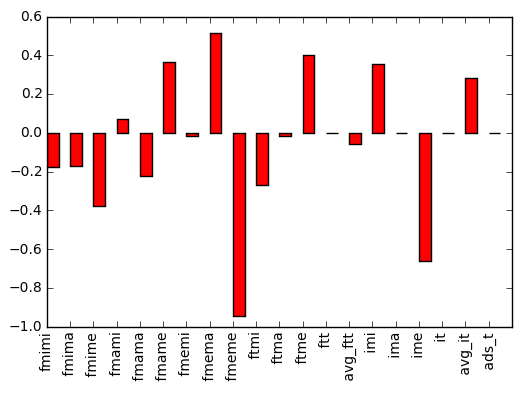

In [105]:
print model.coef_[0]
print_model_weights(model.coef_[0])

In [106]:
data_dict['classifier_model'] = 'random_forest'
results, model = train_and_test_classifier(**data_dict)

[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

[ 0.00133971  0.03159566  0.00564112  0.00993338  0.05690904  0.03585224
  0.00342436  0.03783454  0.00825077  0.00643574  0.07188015  0.04145875
  0.05563019  0.05387068  0.04705855  0.08000553  0.06395805  0.12718688
  0.08721936  0.17451531]


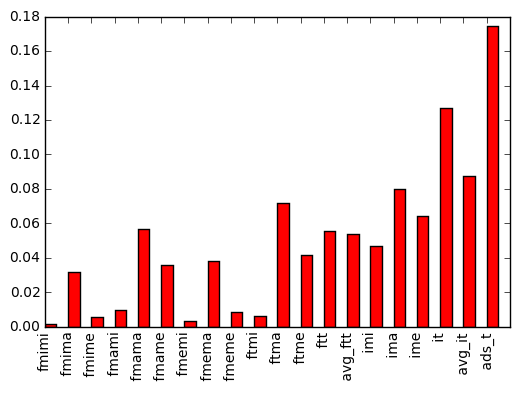

In [107]:
print model.feature_importances_
print_model_weights(model.feature_importances_)

In [108]:
data_dict['classifier_model'] = 'knn'
results, model = train_and_test_classifier(**data_dict)

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0
 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0
 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0
 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1
 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 

In [119]:
# actual evaluation
train_pos_neg_file = os.path.join(data_dir, "train_images_faces_stats_mayank.tsv")
test_pos_neg_file = os.path.join(data_dir, "test_images_faces_stats_mayank.tsv")
data_dict = prepare_train_test_data_separate_unseen(train_pos_neg_file, test_pos_neg_file)
print len(data_dict['train_data']),len(data_dict['train_labels'])
print len(data_dict['test_data']),len(data_dict['test_labels'])
print data_dict['test_labels']

1120 1120
130 1
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [120]:
# 'logistic_regression', 'random_forest', 'knn'
data_dict['classifier_model'] = 'logistic_regression'
results, model = train_and_test_classifier(**data_dict)

[0 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0
 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 0
 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1
 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [121]:
print results

[[u'a99a6739634570f1fbb9de84ddbf07e23c6a0a01', u'8ba21382d6dc205fab0fc6cf8df44116a56acdd0', u'7b189426fb3f9e7f064c90a36b9535ebb7addcea', u'c9f09cb1780306b8c136662c5762c5c4389aa7d7', u'5c2d657f13a027488a9d94f709df02878c6dec62', u'ff9f213f43e0d9ab479af22617dda03bbc4f6e15', u'2eab54f516897c7a30892053cf51924e3c0c7c04', u'b4676faf0ff2d53d156b012f2e30fcf885696f56', u'137003eae9020b75371fbc2096705ca0e0d83172', u'd7e32da2f52840ef88aa1222c93dff5461cbb7e8', u'39b8888fb61cdf580a0e74f8ac02a1ad35aabb36', u'3989e43536a6100c20789671572243d2f4238642', u'2f791ad7f4ab32363a72704c1f93c44450895c6c', u'cc1d3542eba81bf4cf886a12b43becc1e0d3690a', u'30e1338ef1c4663a7f58aa844e56d5429dd458bd', u'509326c19ea93763d1fc710dceecd273b6270b7b', u'7d478f441360ca156c1949c433cf07efd443096a', u'6346c598e16d75fd72bcdb5b630ffa998fe79d8d', u'1904d428f12a6a6f3fb5ee79c13ca5ebf90c1de4', u'c50493d469c2909911ff79baffac52e2f23a1a33', u'a30057883fe42c943365dfa7444af9b1b5e6cf9b', u'4fe14fb5bc4711d3d79f4a782c643e5b3dbdaaf7', u'569494

[ -3.93865237e-01  -1.57149189e-01   4.58832256e-01   2.55910151e-01
  -7.76340544e-02   5.99192996e-02   1.39735913e+00   2.69492338e-01
  -1.31727956e+00  -2.18106139e-01  -6.96740134e-03   1.62046151e-01
   1.08750311e-05  -1.43432609e-01  -5.37348145e-02  -3.55529319e-03
  -1.29864805e-01   2.57205315e-05   1.71065912e-01  -3.26583116e-04]


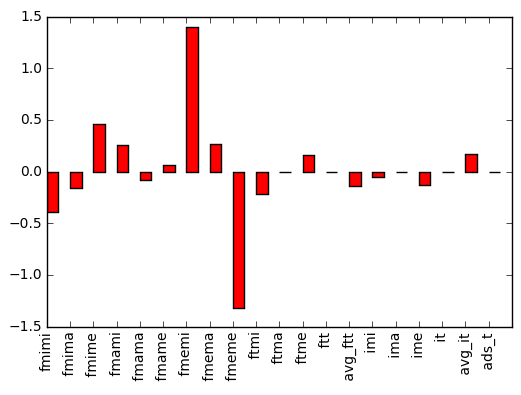

In [122]:
print model.coef_[0]
print_model_weights(model.coef_[0])